In [1]:
using CSV, DataFrames, Dates, Plots

## 1; Dados da pandemia de COVID-19 no Rio de Janeiro


- Os dados obtidos em [1] foram tratados no notebook  01_Tratamento_Dados_Covid_RJ.ipynb .


- Após carregar os dados, precisamos selecionar um ou mais períodos para modelar.

[1] https://www.data.rio/datasets/PCRJ::cep-dos-casos-confirmados-de-covid-19-no-munic%C3%ADpio-do-rio-de-janeiro-1/about

In [2]:
df = DataFrame(CSV.File("DadosMedia.csv"))

,DatasMedia,InfectadosMedia,RecuperadosMedia,ObitosMedia
,Date,Float64,Float64,Float64
1,2020-01-07,6.0,0.0,0.0
2,2020-01-08,6.85714,0.0,0.0
3,2020-01-09,7.57143,0.0,0.0
4,2020-01-10,8.14286,0.142857,0.0
5,2020-01-11,8.57143,0.428571,0.0
6,2020-01-12,8.85714,0.714286,0.0
7,2020-01-13,8.85714,1.0,0.0
8,2020-01-14,8.42857,1.57143,0.0
9,2020-01-15,8.0,2.14286,0.0


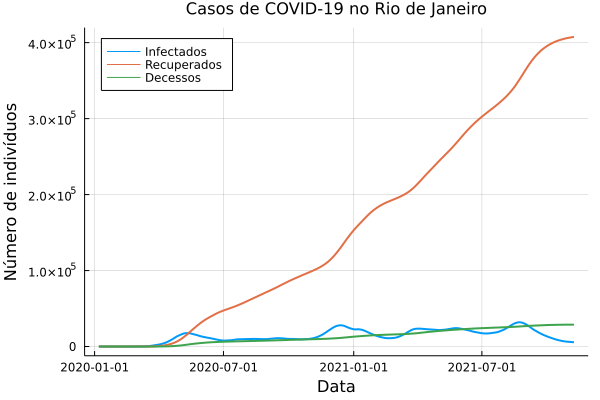

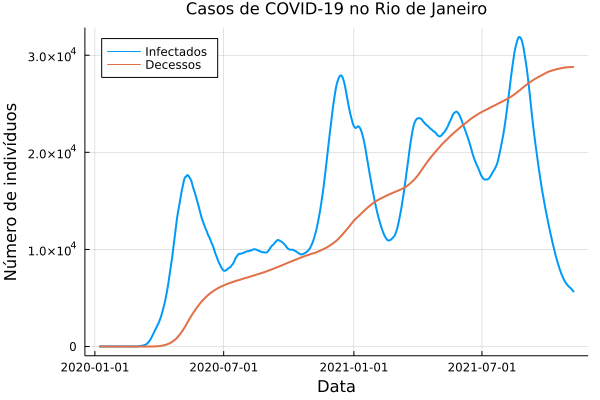

In [3]:
DatasTudo = df[:, "DatasMedia"]
InfTudo = df[:, "InfectadosMedia"]
RecTudo = df[:, "RecuperadosMedia"]
DecTudo = df[:, "ObitosMedia"]

pl = plot(DatasTudo, hcat(InfTudo, RecTudo, DecTudo), label = ["Infectados" "Recuperados" "Decessos"], lw = 2)
plot!(pl, title = "Casos de COVID-19 no Rio de Janeiro", titlefont = 11, gridalpha = 0.22,
    xlabel = "Data", ylabel = "Número de indivíduos", legend = :topleft)
display(pl)

pl = plot(DatasTudo, hcat(InfTudo, DecTudo), label = ["Infectados" "Decessos"], lw = 2)
plot!(pl, title = "Casos de COVID-19 no Rio de Janeiro", titlefont = 11, gridalpha = 0.22,
    xlabel = "Data", ylabel = "Número de indivíduos", legend = :topleft)
display(pl)

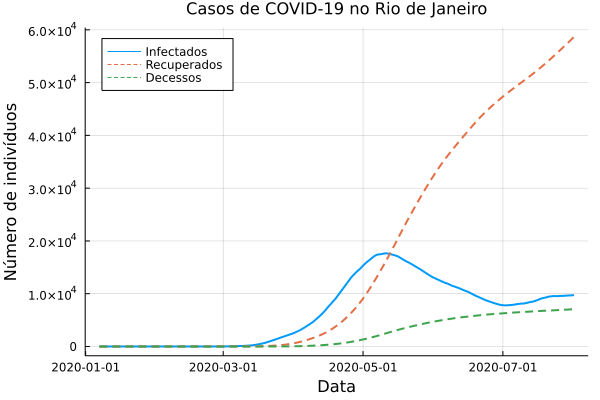

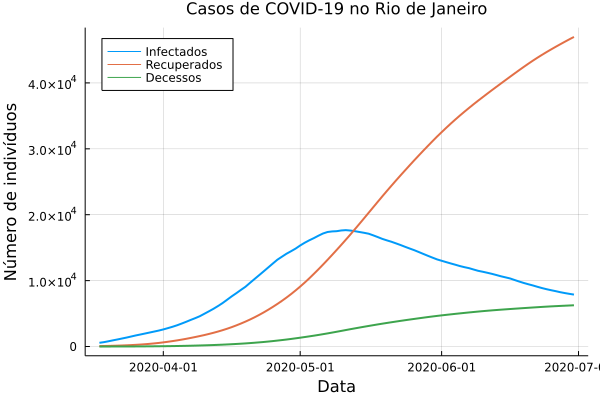

In [4]:
LimiteD = findall(data -> data == Date(2020, 08, 01), DatasTudo)[1]

pl = plot(DatasTudo[1:LimiteD], InfTudo[1:LimiteD], label = "Infectados", lw = 2)
plot!(pl, DatasTudo[1:LimiteD], RecTudo[1:LimiteD], label = "Recuperados", lw = 2, linestyle = :dash)
plot!(pl, DatasTudo[1:LimiteD], DecTudo[1:LimiteD], label = "Decessos", lw = 2, linestyle = :dash)
plot!(pl, title = "Casos de COVID-19 no Rio de Janeiro", titlefont = 11, gridalpha = 0.22,
    xlabel = "Data", ylabel = "Número de indivíduos", legend = :topleft)
display(pl)

LimiteE = findall(data -> data == Date(2020, 03, 18), DatasTudo)[1]
LimiteD = findall(data -> data == Date(2020, 06, 30), DatasTudo)[1]

pl = plot(DatasTudo[LimiteE:LimiteD], InfTudo[LimiteE:LimiteD], label = "Infectados", lw = 2)
plot!(pl, DatasTudo[LimiteE:LimiteD], RecTudo[LimiteE:LimiteD], label = "Recuperados", lw = 2)
plot!(pl, DatasTudo[LimiteE:LimiteD], DecTudo[LimiteE:LimiteD], label = "Decessos", lw = 2)
plot!(pl, title = "Casos de COVID-19 no Rio de Janeiro", titlefont = 11, gridalpha = 0.22,
    xlabel = "Data", ylabel = "Número de indivíduos", legend = :topleft)
display(pl)

In [5]:
DatasOnda = DatasTudo[LimiteE:LimiteD]
InfOnda = InfTudo[LimiteE:LimiteD]
RecOnda = RecTudo[LimiteE:LimiteD]
DecOnda = DecTudo[LimiteE:LimiteD]

nothing

## 2; Ajustando um modelo SIRD

In [6]:
using DifferentialEquations, Optim, Random, Statistics
using Distributions: MvNormal
include("AuxMisc.jl")

- Modelo com parâmetros restritos:

\begin{align*}
    \begin{cases}
        \dot S &\hspace{-0.8em}= -\beta\frac{I}{N}S \\
        \dot I &\hspace{-0.8em}= \beta\frac{I}{N}S - (\gamma_R+\gamma_D)I \\
        \dot R &\hspace{-0.8em}= \gamma_R I \\
        \dot D &\hspace{-0.8em}= \gamma_D I \\
    \end{cases}
\end{align*}

- Modelo com parâmetros $\in \mathbb{R}$:

\begin{align*}
    \begin{cases}
        \dot S &\hspace{-0.8em}= -\hat\beta^2\frac{I}{N}S \\
        \dot I &\hspace{-0.8em}= \hat\beta^2\frac{I}{N}S - (\hat\gamma^2_R+\hat\gamma^2_D)I \\
        \dot R &\hspace{-0.8em}= \hat\gamma^2_R I \\
        \dot D &\hspace{-0.8em}= \hat\gamma^2_D I \\
    \end{cases}
\end{align*}

- Vamos utilizar o segundo modelo.


- Na prática, vamos chamar $\hat\beta$ de $\beta$, etc., para não carregar a notação.

In [7]:
function dudtSIRD!(du, u, θ, t)
    S, I, R, D = u
    β, γ_R, γ_D = θ

    E_novos = β^2 * I*S / (S+I+R+D)
    dS = -E_novos 
    dI = E_novos - (γ_R^2 + γ_D^2)*I
    dR = γ_R^2*I
    dD = γ_D^2*I

    du[1] = dS; du[2] = dI; du[3] = dR; du[4] = dD
end

dudtSIRD! (generic function with 1 method)

### 2.1; Ajuste para os dados do período completo

- Primeiramente, tentaremos ajustar os parâmetros para os dados de todo o período em análise, na expectativa deduzir algumas propriedades do modelo e dos dados.


- Realizaremos o ajuste dos parâmetros $\beta$, $\gamma_R$ e $\gamma_D$ e da condição inicial $S_0$ minimizando $SS(\boldsymbol{r})$ nas variáveis $I$, $R_I$ e $D$:

In [8]:
UltimoDia = convert(Float64,length(DatasOnda))
TimeSpan = (1.,UltimoDia)
Dias = [1:UltimoDia...]
Diass = 1.:0.2:UltimoDia

#PopulacaoTotal = 6748000. # População total da cidade do Rio de Janeiro

u₀Dados = [InfOnda[1], RecOnda[1], DecOnda[1]]

ParametrosIniciais = [50_000, 0.5, 0.5, 0.5]

DadosOnda = hcat(InfOnda,RecOnda,DecOnda)'

ModeloInfRecDec(Parametros) = solve(ODEProblem(dudtSIRD!, [Parametros[1]; u₀Dados], TimeSpan, Parametros[2:end]), 
    saveat = Dias)[[2, 3, 4], :]

Custo(Parametros) = sum(abs2, DadosOnda .- ModeloInfRecDec(Parametros))

Resultado = optimize(Custo, ParametrosIniciais, iterations = 10^4)

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.723856e+08

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   19  (vs limit Inf)
    Iterations:    10000
    f(x) calls:    58135


Parâmetros ajustados:
    β = 0.377
    γ_R = 0.209
    γ_D = 0.078

Parâmetros do modelo restrito:
    β = 0.142
    γ_R = 0.044
    γ_D = 0.006

Suscetíveis iniciais ajustados = 6.34e+4


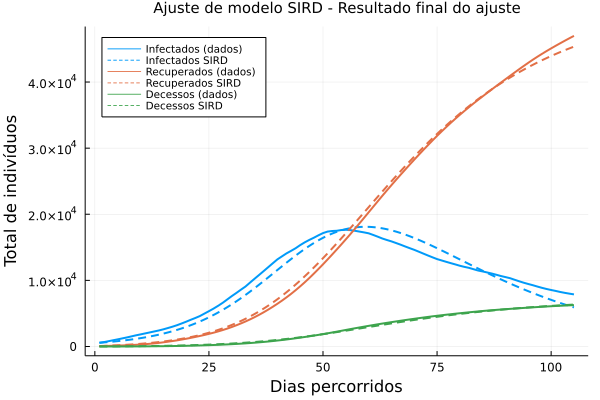

In [9]:
ParametrosFinais = Optim.minimizer(Resultado)
S₀, β, γ_R, γ_D = ParametrosFinais

println("Parâmetros ajustados:
    β = $(round(β, digits=3))
    γ_R = $(round(γ_R, digits=3))
    γ_D = $(round(γ_D, digits=3))")

println("\nParâmetros do modelo restrito:
    β = $(round(β^2, digits=3))
    γ_R = $(round(γ_R^2, digits=3))
    γ_D = $(round(γ_D^2, digits=3))")

s0 = SciRound(S₀)

println("\nSuscetíveis iniciais ajustados = ", s0)

Modelo = solve(ODEProblem(dudtSIRD!, [S₀; u₀Dados], TimeSpan, ParametrosFinais[2:end]), saveat = Diass)

InfModelo = Modelo[2,:]
RecModelo = Modelo[3,:]
DecModelo = Modelo[4,:]

plot(Dias, InfOnda, label = "Infectados (dados)", lw = 2, color = 1)
plot!(Diass,InfModelo, label = "Infectados SIRD", lw = 2, color = 1, linestyle = :dash)
plot!(Dias, RecOnda, label = "Recuperados (dados)", lw = 2, color = 2)
plot!(Diass,RecModelo, label = "Recuperados SIRD", lw = 2, color = 2, linestyle = :dash)
plot!(Dias, DecOnda, label = "Decessos (dados)", lw = 2, color = 3)
plot!(Diass, DecModelo, label = "Decessos SIRD", lw = 2, color = 3, linestyle = :dash)
plot!(title = "Ajuste de modelo SIRD - Resultado final do ajuste", titlefont = 10,
    xlabel = "Dias percorridos", ylabel = "Total de indivíduos", legend = :topleft, legendfont = 7)

### 2.2; Ajuste para dados dos $N$ primeiros dias


- Vamos ajustar os parâmetros do modelo utilizando somente os dados dos $N$ primeiros dias para testar sua capacidade de previsão.

In [10]:
function AjusteNPrimeirosDias(N; InfOnda = InfOnda, RecOnda = RecOnda, DecOnda = DecOnda, u₀Dados = u₀Dados,
        ParametrosIniciais = ParametrosIniciais, NumIter = 10^4, MostrarLegenda = true, yLim = 30000)
    
    UltimoDia = convert(Float64,length(DatasOnda))
    TimeSpan = (1.,UltimoDia)
    Dias = [1:UltimoDia...]
    Diass = 1.:0.2:UltimoDia

    DiasTreino = [1:N...]
    DadosTreino = hcat(InfOnda[1:N], RecOnda[1:N], DecOnda[1:N])'
    
    ModeloTreino(Parametros) = solve(ODEProblem(dudtSIRD!, [Parametros[1]; u₀Dados], TimeSpan, Parametros[2:end]), 
        saveat = DiasTreino)[[2, 3, 4], :]
    
    Custo(Parametros) = sum(abs2, DadosTreino .- ModeloTreino(Parametros))
    Resultado = optimize(Custo, ParametrosIniciais, iterations = NumIter)
    
    ParametrosFinais = Optim.minimizer(Resultado)
    S₀, β, γ_R, γ_D = ParametrosFinais
    
    Modelo = solve(ODEProblem(dudtSIRD!, [S₀; u₀Dados], TimeSpan, ParametrosFinais[2:end]), saveat = Diass)

    InfModelo = Modelo[2,:]
    RecModelo = Modelo[3,:]
    DecModelo = Modelo[4,:]

    pl = plot(Dias, InfOnda, label = "Infectados - dados", lw = 2, color = 1)
    plot!(pl, Diass, InfModelo, label = "Infectados - SIRD", lw = 2, linestyle = :dash, color = 1)

    plot!(pl,Dias, RecOnda, label = "Recuperados - dados", lw = 2, color = 2)
    plot!(pl, Diass, RecModelo, label = "Recuperados - SIRD", lw = 2, linestyle = :dash, color = 2)

    plot!(pl,Dias, DecOnda, label = "Decessos - dados", lw = 2, color = 3)
    plot!(pl, Diass, DecModelo, label = "Decessos - SIRD", lw = 2, linestyle = :dash, color = 3)
    
    plot!(pl, [N], seriestype = "vline", label = "Último dia do ajuste", color = "red")
    
    plot!(pl, title = "Ajuste de modelo SIRD com $N dias de treino", titlefont = 11, xlabel = "Dias percorridos",
        ylabel = "Total de indivíduos", legend = MostrarLegenda, legendfont = 7, ylim = (-500, yLim))
    display(pl)
   
    nothing
end

AjusteNPrimeirosDias (generic function with 1 method)

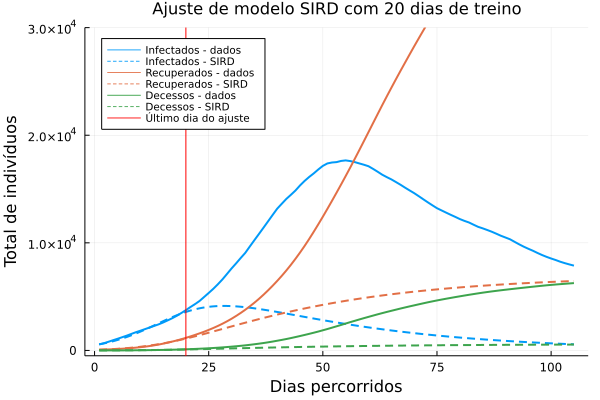

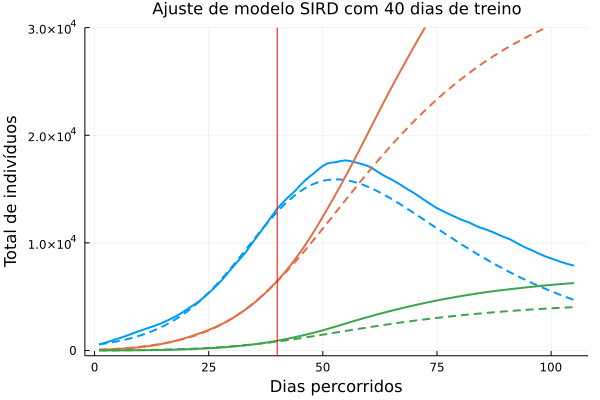

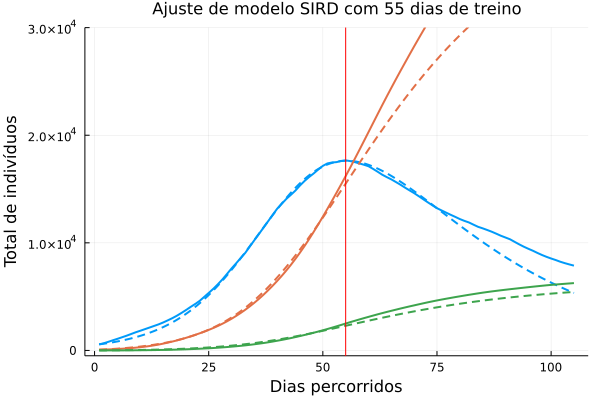

In [11]:
AjusteNPrimeirosDias(20, MostrarLegenda = :topleft)

AjusteNPrimeirosDias(40, MostrarLegenda = false)

AjusteNPrimeirosDias(55, MostrarLegenda = false)